In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, fourier_gaussian
from scipy.special import gamma
from scipy.optimize import curve_fit

import sys
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')
import pitszi

# Parameters

In [2]:
Nx, Ny = 128, 128
proj_reso = 10.0

Linj = 0.5e5
slope = 11/3.0

beam = 30
appMask = True
smooth_mask = 50

In [3]:
sigma2fwhm = 2 * np.sqrt(2*np.log(2))

# Image generation

In [4]:
def pk_model(k_in):
    return k_in**(-slope) * np.exp(-(1/(k_in*Linj)**2))

def gen_fluct():    
    field = np.random.normal(loc=0, scale=1, size=(Nx,Ny))
    fftfield = np.fft.fftn(field) * amplitude
    fluctuation = np.real(np.fft.ifftn(fftfield))     
    return fluctuation

k_x = np.fft.fftfreq(Nx, proj_reso) # 1/kpc
k_y = np.fft.fftfreq(Ny, proj_reso)

k2d_x, k2d_y = np.meshgrid(k_x, k_y, indexing='ij')
k2d_norm = np.sqrt(k2d_x**2 + k2d_y**2)
k2d_norm_flat = k2d_norm.flatten()

kmin = np.amin(k2d_norm[k2d_norm >0])
kmax = np.amax(k2d_norm)
k = np.logspace(np.log10(kmin),np.log10(kmax), 1000)
P2d_k = pk_model(k)

itpl = interp1d(k, P2d_k, kind='linear', fill_value=0, bounds_error=False)
P2d_k_grid_flat = itpl(k2d_norm_flat)
P2d_k_grid = P2d_k_grid_flat.reshape(Nx, Ny)
P2d_k_grid[k2d_norm == 0] = 0

amplitude =  np.sqrt(P2d_k_grid / (proj_reso*proj_reso))

fluctuation = gen_fluct()

# Masking and smoothing

Text(0.5, 1.0, 'mask')

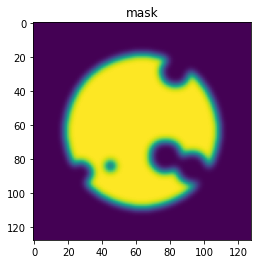

In [5]:
mask = fluctuation*0+1

x = np.linspace(-int(Nx/2), int(Nx/2), Nx)*proj_reso
y = np.linspace(-int(Ny/2), int(Ny/2), Nx)*proj_reso
xx, yy = np.meshgrid(x, y, indexing='ij')
rad = (xx**2 + yy**2)**0.5
mask[rad>0.5*np.amax(rad)] = 0

for isrc in range(10):
    rad = ((xx-np.random.uniform(-int(Nx/2), int(Nx/2))*proj_reso)**2 + (yy-np.random.uniform(-int(Ny/2), int(Ny/2))*proj_reso)**2)**0.5
    mask[rad<np.random.uniform(proj_reso,10*proj_reso)] = 0

mask = gaussian_filter(mask, sigma=smooth_mask/sigma2fwhm/proj_reso)

if not appMask:
    mask = mask*0+1

plt.imshow(mask)
plt.title('mask')

In [6]:
#fluctuation_sm = gaussian_filter(fluctuation, sigma=beam/sigma2fwhm/proj_reso, mode='warp') * mask
FT_map = np.fft.fft2(fluctuation)
FT_map_sm = fourier_gaussian(FT_map, sigma=beam/sigma2fwhm/proj_reso)
fluctuation_sm = np.real(np.fft.ifft2(FT_map_sm)) * mask

Text(0.5, 1.0, 'fluctuation')

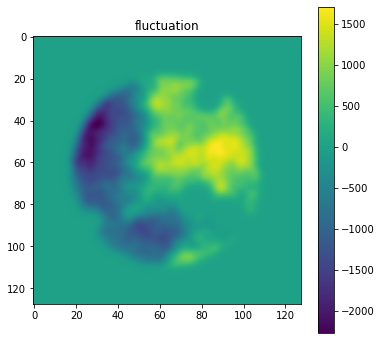

In [7]:
fig = plt.figure(0, figsize=(6, 6))
plt.imshow(fluctuation_sm)
plt.colorbar()
plt.title('fluctuation')

# Pk measurement

In [8]:
def meas_Pk_naive(fluct):
    k_naive, pk_naive = pitszi.utils_pk.extract_pk2d(fluct, proj_reso, Nbin=100)
    pk_naive *= mask.size/np.sum(mask)
    pk_naive = pk_naive / pitszi.utils_pk.beam_wf_pk(k_naive, beam)**2
    return k_naive, pk_naive

def meas_Pk_a12(fluct):
    k_a12, pk_a12 = pitszi.utils_pk.extract_pk2d_arevalo(fluct, proj_reso, Nbin=100, mask=mask)
    
    #der = -np.gradient(np.log10(pk_a12), np.log10(k_a12))
    #der = -np.gradient(np.log10(pk_model(k_a12)), np.log10(k_a12))
    der = slope
    _, pk_a12_corr1 = pitszi.utils_pk.extract_pk2d_arevalo(fluct, proj_reso, Nbin=100, mask=mask, 
                                                           unbias_apply=True, unbias_slope=der)
    _, pk_a12_corr2 = pitszi.utils_pk.extract_pk2d_arevalo(fluct, proj_reso, Nbin=100, mask=mask, 
                                                           unbias_apply=True, unbias_slope=der, 
                                                           unbias_beamFWHM=beam)    
    return k_a12, pk_a12, pk_a12_corr1, pk_a12_corr2

In [9]:
k_naive, pk_naive = meas_Pk_naive(fluctuation_sm)
k_a12, pk_a12, pk_a12_corr1, pk_a12_corr2 = meas_Pk_a12(fluctuation_sm)

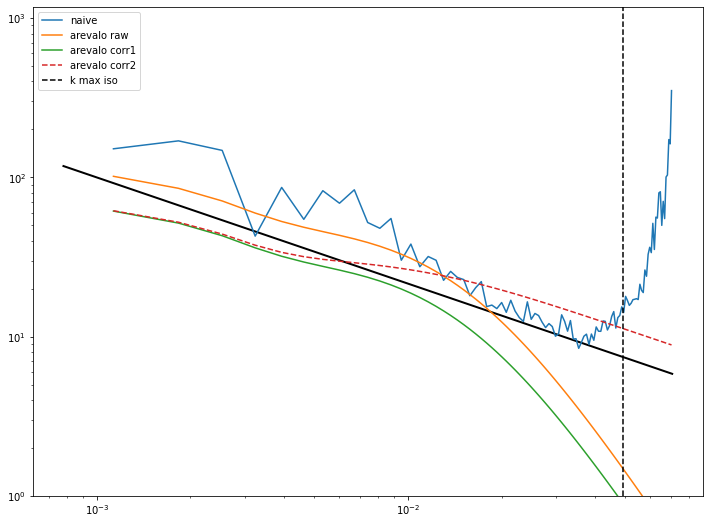

In [10]:
fig = plt.figure(0, figsize=(12, 9))
plt.loglog(k,       k**3*P2d_k, lw=2, color='k')
plt.loglog(k_naive, k_naive**3*pk_naive, label='naive')
plt.loglog(k_a12,   k_a12**3*pk_a12, label='arevalo raw')
plt.loglog(k_a12,   k_a12**3*pk_a12_corr1, label='arevalo corr1', lw=1.5)
plt.loglog(k_a12,   k_a12**3*pk_a12_corr2, label='arevalo corr2', ls='--')
plt.axvline(np.amax(k2d_x), color='k', ls='--', label='k max iso')
plt.ylim(1e0, np.amax(k**3*P2d_k)*10)
plt.legend()

# Perform MC realization for stats

In [11]:
Nmc = 30
Pks_N = np.zeros((Nmc, len(pk_naive)))
Pks_A = np.zeros((Nmc, len(pk_a12)))
Pks_A1 = np.zeros((Nmc, len(pk_a12_corr1)))
Pks_A2 = np.zeros((Nmc, len(pk_a12_corr2)))

for imc in range(Nmc):
    fluctuation = gen_fluct()
    FT_map = np.fft.fft2(fluctuation)
    FT_map_sm = fourier_gaussian(FT_map, sigma=beam/sigma2fwhm/proj_reso)
    fluctuation_sm = np.real(np.fft.ifft2(FT_map_sm))*mask
    
    k_naive, pk_naive = meas_Pk_naive(fluctuation_sm)
    k_a12, pk_a12, pk_a12_corr1, pk_a12_corr2 = meas_Pk_a12(fluctuation_sm)
    
    Pks_N[imc,:] = pk_naive
    Pks_A[imc,:] = pk_a12
    Pks_A1[imc,:] = pk_a12_corr1
    Pks_A2[imc,:] = pk_a12_corr2

(1.0, 1178.1177352718)

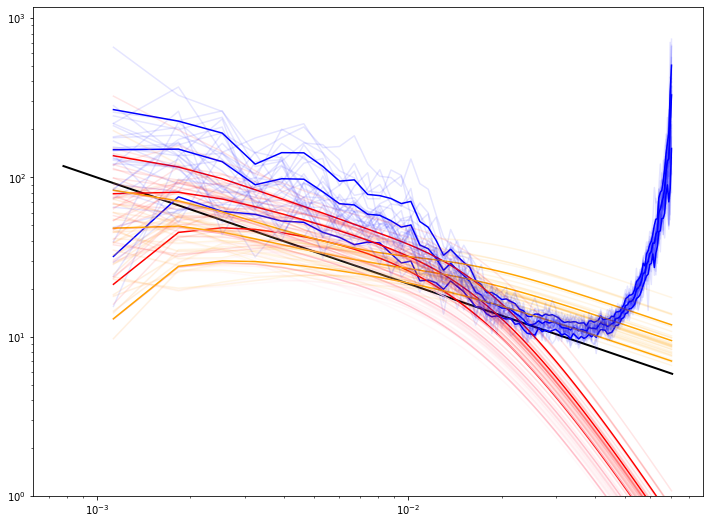

In [12]:
fig = plt.figure(0, figsize=(12, 9))
plt.loglog(k, k**3*P2d_k, lw=2, color='k')

plt.loglog(k_naive, np.mean(Pks_N,axis=0)*k_naive**3, color='b')
plt.loglog(k_naive, (np.mean(Pks_N,axis=0)+np.std(Pks_N,axis=0))*k_naive**3, color='b')
plt.loglog(k_naive, (np.mean(Pks_N,axis=0)-np.std(Pks_N,axis=0))*k_naive**3, color='b')

plt.loglog(k_naive, np.mean(Pks_A,axis=0)*k_naive**3, color='r')
plt.loglog(k_naive, (np.mean(Pks_A,axis=0)+np.std(Pks_A,axis=0))*k_naive**3, color='r')
plt.loglog(k_naive, (np.mean(Pks_A,axis=0)-np.std(Pks_A,axis=0))*k_naive**3, color='r')

plt.loglog(k_naive, np.mean(Pks_A1,axis=0)*k_naive**3, color='pink')
plt.loglog(k_naive, (np.mean(Pks_A1,axis=0)+np.std(Pks_A1,axis=0))*k_naive**3, color='pink')
plt.loglog(k_naive, (np.mean(Pks_A1,axis=0)-np.std(Pks_A1,axis=0))*k_naive**3, color='pink')

plt.loglog(k_naive, np.mean(Pks_A2,axis=0)*k_naive**3, color='orange')
plt.loglog(k_naive, (np.mean(Pks_A2,axis=0)+np.std(Pks_A2,axis=0))*k_naive**3, color='orange')
plt.loglog(k_naive, (np.mean(Pks_A2,axis=0)-np.std(Pks_A2,axis=0))*k_naive**3, color='orange')

for imc in range(Nmc):
    plt.loglog(k_naive, Pks_N[imc,:]*k_naive**3, color='b', alpha=0.1)
    plt.loglog(k_naive, Pks_A[imc,:]*k_naive**3, color='red', alpha=0.1)
    plt.loglog(k_naive, Pks_A1[imc,:]*k_naive**3, color='pink', alpha=0.1)
    plt.loglog(k_naive, Pks_A2[imc,:]*k_naive**3, color='orange', alpha=0.1)
plt.ylim(1e0, np.amax(k**3*P2d_k)*10)

(0.5, 2.0)

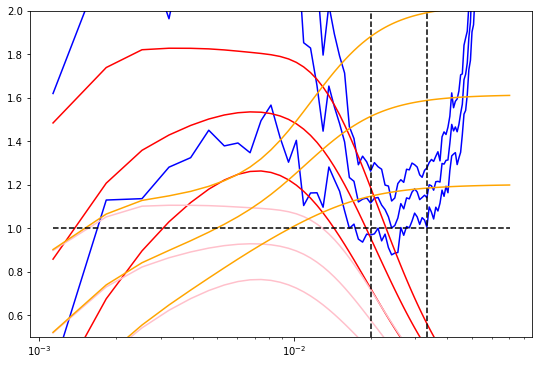

In [13]:
pk_th = pk_model(k_naive)

fig = plt.figure(0, figsize=(9, 6))

plt.plot(k_naive, np.mean(Pks_N,axis=0) / pk_th, color='b')
plt.plot(k_naive, (np.mean(Pks_N,axis=0)+np.std(Pks_N,axis=0))/pk_th, color='b')
plt.plot(k_naive, (np.mean(Pks_N,axis=0)-np.std(Pks_N,axis=0))/pk_th, color='b')

plt.plot(k_naive, np.mean(Pks_A,axis=0)/pk_th, color='r')
plt.plot(k_naive, (np.mean(Pks_A,axis=0)+np.std(Pks_A,axis=0))/pk_th, color='r')
plt.plot(k_naive, (np.mean(Pks_A,axis=0)-np.std(Pks_A,axis=0))/pk_th, color='r')

plt.plot(k_naive, np.mean(Pks_A1,axis=0)/pk_th, color='pink')
plt.plot(k_naive, (np.mean(Pks_A1,axis=0)+np.std(Pks_A1,axis=0))/pk_th, color='pink')
plt.plot(k_naive, (np.mean(Pks_A1,axis=0)-np.std(Pks_A1,axis=0))/pk_th, color='pink')

plt.plot(k_naive, np.mean(Pks_A2,axis=0)/pk_th, color='orange')
plt.plot(k_naive, (np.mean(Pks_A2,axis=0)+np.std(Pks_A2,axis=0))/pk_th, color='orange')
plt.plot(k_naive, (np.mean(Pks_A2,axis=0)-np.std(Pks_A2,axis=0))/pk_th, color='orange')

plt.plot(k_naive, k_naive*0+1, ls='--', color='k')

if smooth_mask>0: plt.axvline(1/smooth_mask, color='k', ls='--', label='smooth mask')
if beam>0: plt.axvline(1/beam, color='k', ls='--', label='beam')
plt.xscale('log')
plt.ylim(0.5, 2)